In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from pattern.nl import parse, split
from collections import Counter
from gensim.models import KeyedVectors
# Need the interactive Tools for Matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from adjustText import adjust_text
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from random import sample
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
import seaborn as sns


stopz = 'http://rubenros.nl/wp-content/uploads/2019/08/stopwords-nl.txt'
req = requests.get(stopz)
stopz = str(req.content)
stopz = stopz.split('\\n')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
os.chdir('E:/Rampen/text')
l = sorted(glob.glob('*articles.txt'))

In [10]:
def PMIW(start_year,end_year, keyword,window):
    
    files = [f for f in l if int(f[0:4]) >= start_year and int(f[0:4]) <= end_year]
    
    
    d = dict()
    lines = []
    ## Load
    for filename in files:
        with open(filename,'r',encoding='utf-8') as f:
            lines += f.readlines()
    print(len(lines))
    
    if len(lines) > 100000:
        lines = sample(lines,100000)
        
    vocab = dict(Counter([item for sublist in lines for item in sublist.split(' ')]))
    print(vocab[keyword])
    vocab = {k:v for k,v in vocab.items() if len(k) > 3 and len(k) < 15 and v > 5 and k not in stopz}
    d[keyword] = vocab[keyword]
    
    if keyword not in vocab.keys():
        print("too little instances of keyword")
        return
    
    vocab = {k:v for k,v in vocab.items() if len(k) > 3 and len(k) < 15 and v > 10}
    ## Count Tot Len
    linecount = len(lines)
    
    ## Subset Lines with Keyword and give freq
    lines = [l.split(' ') for l in lines]
    lines = [l for l in lines if keyword in l]
    #print("{} lines subsetted".format(len(lines)))
    
    
    ## Loop over Lines > Loop over Vocabulary Words
    for line in lines:
        for secword in vocab:
            d[secword] = vocab[secword]
            
            if secword in line and keyword in line:
                occs_keyword = [i for i, x in enumerate(line) if x == keyword]
                occs_keyword = [i for i in occs_keyword if i] 
                for ins in occs_keyword:
                    left = ins - window
                    right = ins + window
                    if left < 0:
                        left = 0
                    if right > len(line):
                        right = len(line)
                    if any(word in line[left:right] for word in vocab):
                        for secword in [w for w in line[left:right] if w in vocab]:
                            if keyword + "_" + secword in d.keys():
                                d[keyword + "_" + secword] += 1
                            else:
                                d.update({keyword + "_" + secword:1})            
    #print('looping done')
    pmidict = dict()    
    for secword in vocab.keys():
        
        if keyword + "_" + secword in d.keys():
            p1 = d[keyword] / linecount
            p2 = d[secword] / linecount
            p12 = d[keyword + "_" + secword] / linecount            
            try:
                pmi = math.log((p12) / (p1 * p2))
            except ValueError:
                continue            
            pmidict.update({secword:[pmi,p1,p2,p12]})
            #print(filename[0:4] + " | " + secword + " | " + str(pmi))            
        else:
            continue
    #print([k for k,v in dict(Counter(pmidict).most_common(5)).items()])  
    return dict(Counter(pmidict))

In [12]:
rd = dict()
for i in range(0,99,15):
    rd.update({l[i][0:4]:PMIW(int(l[i][0:4]),int(l[i][0:4]) + 10,'rampen',18)})

93106
390
151190
276
163032
383
236194
396
212464
790
241818
603
318016
440


In [13]:
dictionary_pmi = rd
df = pd.DataFrame()

# Convert
for key in dictionary_pmi.keys():
    t = {k:v[0] for k,v in dictionary_pmi[key].items()}
    d = pd.DataFrame(list(t.items()),columns=['gram','pmi'])
    d = d[d['gram'] != "ramp"]
    d['year'] = key
    df = df.append(d)
df = df.pivot(columns='year',index='gram',values='pmi')
df = df.reset_index()
df=df.fillna(0)

# Subset Only Top/Year
#list_ss = []
#for y in df.columns[1:]:
#    t = df.sort_values(y,ascending=False)
#    t = t['gram'][0:10] #
#    list_ss= list_ss + list(t)

#df = df[df['gram'].isin(list(set(list_ss)))]

In [14]:
os.chdir('C:/Users/Ruben/Documents/Artikelen/Disasters/output-data')
df.to_csv('pmi-df-rampen-sli10-15y-w18.csv')

created list with 188 words


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0: aanmoedigingen, bilderdijk, deelgenoten, droef, eloor, ftelzel, geruststelling, gevangenneming, gewaagt, huishoudkunde, indachtig, insecten, inzigten, koopstad, landvoogd, leydens, lierzang, medicament, nacionale, negens, product, schouwtooneel, stapelen, studiën, styl, toelland, vertelling, waardiglijk, waterwerken, zevenjarigen


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1: achteloosheid, afwending, akelig, algemeenheid, barbaarschheid, behoed, geduchte, gevreesde, lafheid, leeniging, leniging, misgewas, ondergane, ongevoelig, onherstelbare, onmatige, overmaat, straf, tegenfpoed, verbeelding, vooroordeelen, voorteekenen, vreeselijke, vreesselijken, weerlooze, zoovele, zuinigheid, zwaarste
2: aanbeval, aanvaller, begroeten, behoede, bejegenen, belaas, derft, dragelijk, dreigden, droevigen, eerbiedigt, evenaren, fparen, gevoeligen, gevoeliger, goddelijken, kinderlijk, klonken, leenigen, lijdend, loonde, nederige, noeg, ongaarne, ontluikende, ontnam, ontvallen, openhartigheid, scheurde, verbloemen, verzachten
3: aangericht, afgekeerd, afgemaaid, beijverd, berokkend, deinzen, dreven, geftelt, gehinderd, geleed, gelenigd, geordend, gewapenderhand, geweien, gewogen, gezon, gezonder, ingespannen, omringd, overgekomen, overkomen, overlegd, tnans, uitgezet, verlatten, zekerd, zinken, „deze
4: aigemeenen, ajax, alli, berigtende, berm, bewyzén, bourne, bovengaand

<Figure size 720x432 with 0 Axes>

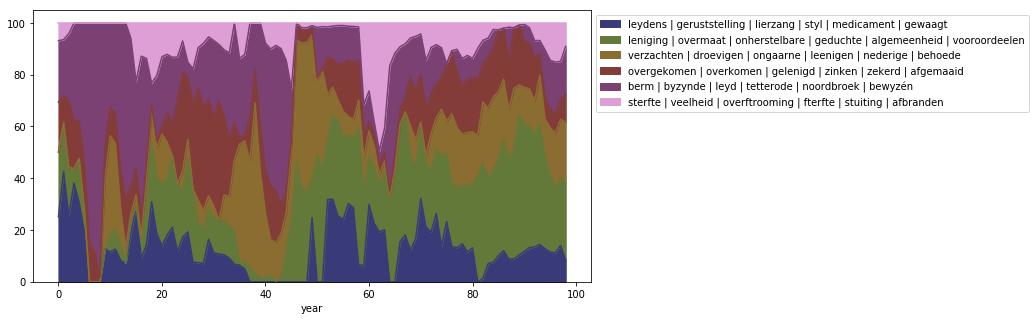

In [72]:
matrix = MatrixPeriod(0.005,df)
cdf = ClusterWord(matrix,6)
dtw = GetClusterNames(cdf, df, list(range(0,99)))
cs = ClusterDf(cdf, df, range(0,99), dtw)

In [29]:
def MatrixPeriod(freq_threshold, df):
    
    df = pd.melt(df, id_vars=['gram'])
    df['year'] = df['year'].astype(int)
    df['year'] = 'tot_count'
    df = df.groupby(['gram']).sum()
    
    list_words = list(df[df['value'] > freq_threshold].index)
    
    
    dmx = DistanceMatrix(list_words, model)
    
    return dmx

def DistanceMatrix(list_words, model):
    
    list_words = [w for w in list_words if w in list(model.wv.vocab.keys())]
    print("created list with " + str(len(list_words)) + " words")

    total_list = list()
    
    for word in list_words:
        
        list_word = list()
        
        for term in list_words:
            #tmp = model.distance(word, term)
            tmp = model.similarity(word, term)

            list_word.append(tmp)
        
        total_list.append(list_word)
    df = pd.DataFrame(total_list, columns = list_words, index = list_words)
    return df

def ClusterWord(matrix, k):
    centroids,_ = kmeans(matrix,k)
    idx,_ = vq(matrix,centroids)
    
    return dict(zip(list(matrix.index), idx))


def GetClusterNames(clus_dict, df, range_df):

    
    df = df[df.gram.isin([k for k,v in clus_dict.items()])]
    
    dict_topwords_cluster = dict()
    
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        print(str(cluster_id) + ": " + ", ".join(list_words_cluster))
        print('=======')
        
        tmpdf = df[df.gram.isin(list_words_cluster)]
        tmpdf['word_sum'] = tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=1)
        
        topwords = list(tmpdf.nlargest(6,'word_sum').gram)
        topwords = " | ".join(topwords)
        dict_topwords_cluster.update({str(cluster_id):topwords})
        
        
    return dict_topwords_cluster

def ClusterDf(clus_dict, df, range_df, dict_topwords_cluster):

    
    df = df[df.gram.isin([k for k,v in clus_dict.items()])]
    
    cluster_sums_dict = dict()
    
    # Calculate Diachronic Sums of Clusters
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        
        tmpdf = df[df.gram.isin(list_words_cluster)]
        
        tmpdf_sums = list(tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=0))
        
        cluster_sums_dict.update({cluster_id:tmpdf_sums})
        
    cluster_sums = pd.DataFrame.from_dict(cluster_sums_dict)
    cluster_sums['year'] = range_df
    cluster_sums.columns = cluster_sums.columns.astype(str)
    
    cluster_sums['sum'] = cluster_sums.iloc[:,0:len(cluster_sums.columns)-1].sum(axis=1)
    
    for column in list(cluster_sums.columns)[0:len(cluster_sums.columns)-2]:
        cluster_sums[column] = cluster_sums[column] / cluster_sums['sum'] * 100
    
    range_years = [str(y) for y in list(cluster_sums.columns)[0:len(cluster_sums.columns)-2]]
    
    ### Set top words as labels
    cluster_sums.columns = list([v for k,v in dict_topwords_cluster.items()]) + ['year','sum']    # + 'sum' in []
    cluster_sums['year'] = cluster_sums['year'].astype(str)
    cluster_sums = cluster_sums.astype(float)
    cluster_sums[cluster_sums < 0] = 0
    plt.figure(figsize=(10,6))
    cluster_sums.plot(x="year", y = list([v for k,v in dict_topwords_cluster.items()]), kind="area", colormap = "tab20b", figsize=(10,5)).legend(bbox_to_anchor=(1, 1))

    return cluster_sums

In [191]:
def PlotWords(df, input_term, model, start_year,end_year):
    list_words = [k for k,v in model.most_similar(input_term, topn=10)] + input_term
    
    for c in df.columns[1:]:
        df[c] = df[c] / df[c].sum()
    
    tdf = df[df['gram'].isin(list_words)].T
    list_words = list(tdf.iloc[0,])
    tdf.columns = list_words
    tdf = tdf.iloc[1:,:]
    tdf['y'] = tdf.index.astype(int)
    tdf = tdf[(tdf['y'] >= start_year) & (tdf['y'] <= end_year)]
    #tdf.plot.area(x='y',y=list_words,figsize=(15,7))
    
    tdf= tdf.reset_index(drop=True)

    col = sns.color_palette("tab20b", len(list_words))
    x_lab = "Years"
    y_lab = "Absolute Frequency"
    title = "Collocates most similar to: " + " ".join(input_term)
    
    x_values = list(tdf['y'])
    y_values = [list(tdf[c]) for c in list_words]
    fig, ax = plt.subplots(facecolor='white',figsize=(30, 10))
    labels = list_words
    
    plt.stackplot(x_values,y_values, labels=list_words, colors = col) #baseline="wiggle", 
    plt.legend(loc='upper left')

    ax.set_facecolor("white")
    box = ax.get_position()
    hfont = {'fontname':'Helvetica'}

    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    lgd = ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.06))
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color("white")
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_edgecolor("white")
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=14)

    plt.title(title, fontsize=18)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


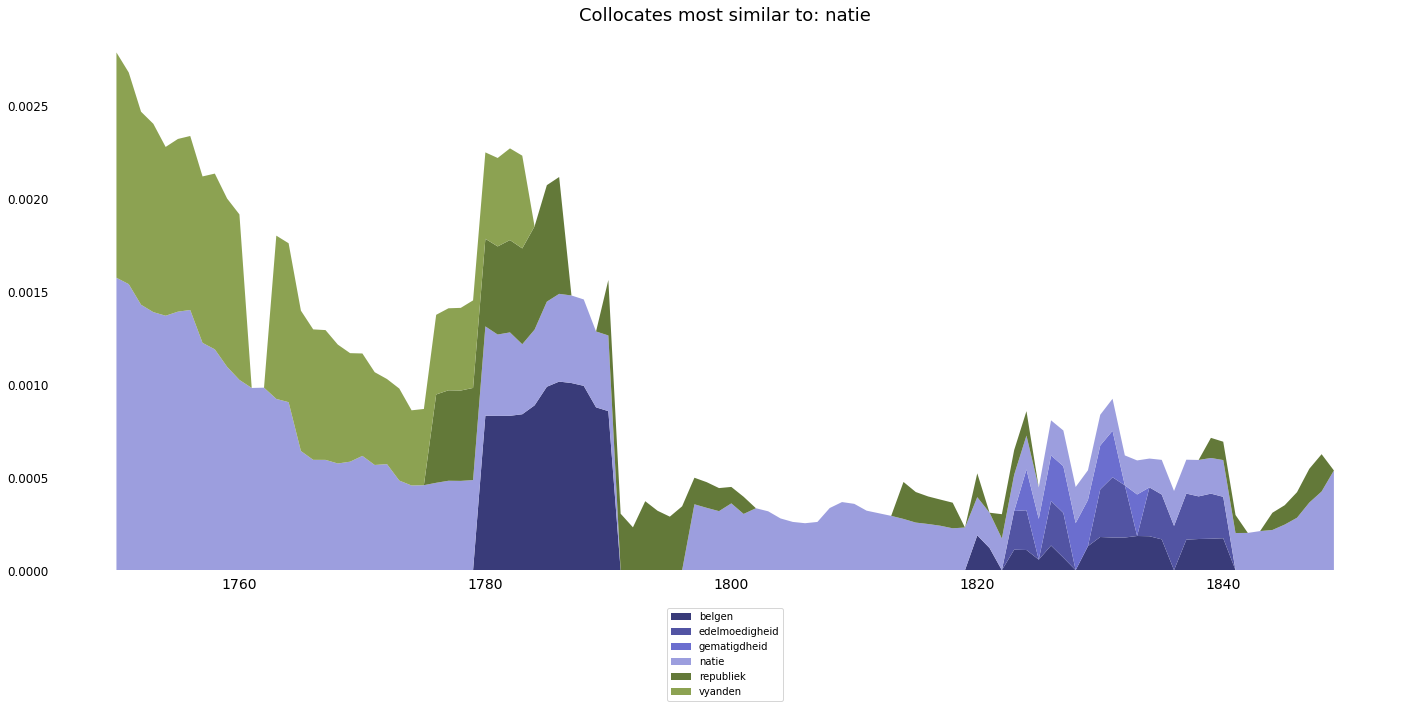

In [197]:
PlotWords(df, ['natie'], model, 1750, 1850)

In [186]:
df['1750'].sum()

3647.804847769903

In [150]:
df

year,gram,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
0,0111,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,5.069749,0.000000,3.141961,3.594824,3.487892,3.939387,5.549808,7.445480,0.000000,0.000000
1,011s,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.932699,1.109224,1.112323,1.284118,0.358133,0.361586,0.483774,0.249519,0.307528,0.396298
3,10000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,7.931170,8.139288,8.322840,8.926427,0.000000,4.002504,5.212770,6.538084,7.595879,9.693587
4,100000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,10den,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,1.689701,1.329256,1.216738,1.189918,1.121918,0.000000,0.000000,0.000000,0.000000,0.000000
6,1100,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,17.964359,17.940633,17.363824,20.491800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,11000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1200,0.0,0.0,0.0,0.0,67.052067,58.369674,63.148375,61.259001,62.82841,...,1.922231,1.840519,1.863764,2.205505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,12000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,...,5.307810,17.396803,17.240741,17.704765,12.556239,11.601378,14.908704,0.000000,0.000000,0.000000


[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  75.3308418725216,
  60.97378496361432,
  53.35849477557957,
  42.766002493325104,
  38.203762781090596,
  34.11732038346408,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  12.211962013993356,
  24.134874426168654,
  24.557259840634497,
  22.14064523146386,
  17.15542302020906,
  18.886220553582575,
  47.105266518449774,

In [140]:
t

,elementen,gewesten,landstreek,lauden,monarchie,nabuurschap,natie,oorden,streken,volken,volkeren,volkeu,volkplantingen,vorsten,y
0,0,0,0,0,0,0,4.68543,0,0,0,0,0,0,0,1780
1,0,0,0,0,0,0,4.66669,0,0,0,0,0,0,0,1781
2,0,0,0,0,0,0,5.00025,0,0,0,0,0,0,0,1782
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1783
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1784
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1785
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1786
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1787
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1788
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1789
